# Clustering with matplotlib

## Table of Contents

* Introduction
  * TBD
* Creating a Custom Cluster with ZeroMQ
  * Goal
  * About ZeroMQ
  * Estimating $\pi$
  * Creating the ZeroMQ Components
  * Working with Results
* Clusting with IPython
  * About Parallelism in IPython
  * Getting Started
  * Direct View
  * Cell Magics
  * Example: Estimating $\pi$
  * Example: Computing Periods of Stars
* MIT's StarCluster
  * About StarCluster
  * Code and Images
  * Configuring StarCluster
  * Starting a Cluster
  * Running a Job
  
Before we get started, let's do our usual warm-up proceedure:

In [1]:
import matplotlib
matplotlib.use('nbagg')
%matplotlib inline

Let's bring in some of the modules we'll be needing as well:

In [2]:
import multiprocessing, os, random, sys, time
    
import zmq

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import Image

sys.path.append("../lib")
import collector, demo, democfg, nbutil, processor

We can re-use our custom style from a couple notebook ago, too:

In [3]:
plt.style.use("../styles/superheroine-2.mplstyle")
colors = plt.rcParams['axes.color_cycle']

## Introduction

Though the focus of the last notebook was big data, we touched on topics closely related to this notebook's area of exploration: clustering for matplotlib. Now we're going to take some time to work through some clustering examples and see howto use matplotlib in such senarios.

First, though, we should define some terms: what is clustering? We use the term in a very general sense: a system of computing nodes across which a task may be split up whose parts may be executed in parallel on all the system nodes. The nodes may be a collection of processes on the same machine, or on a computer network; they may also be virtual machines or physical computers on a network. The term "cluster" alludes to a logical collection, but in our definition, there is a more important word: "parallel." For our purposes, clusters exist to make running code in parallel more efficient or convenient.

Which leads us to the next natural question: what is parallel computing? The idea behind writing parallel programs is to write code such that computational work may be split up and run concurrently. In 2005, a greater number of mainstream programmers become interested in parallel computing as a result of the famous article by Herb Sutter [The Free Lunch Is Over](http://www.gotw.ca/publications/concurrency-ddj.htm). 10 years later, we continue to see gains in computing power through the addition of cores and the message remains just as pertinent to use now (if not more so). For more information on parallel computing, be sure to check out the excellent [Introduction to Parallel Computing](https://computing.llnl.gov/tutorials/parallel_comp/) by Blaise Barney (Lawrence Livermore National Laboratory).

There are several ways in which one may write parallel code, but our focus will be on the following:
 * data parallization - where the same calculation is performed on different data sets (and sometimes the same data sets)
 * task parallization - where a task is decomposed into sub-tasks and the sub-tasks are executed in parallel

The sorts of problems that are most amenable to parallelization include those in the following fields:

* n-body problems (e.g., simulating phsysics for understanding the structure of physical reality; see the [Millennium Run](http://en.wikipedia.org/wiki/Millennium_Run))
* Structured grid problems (e.g., computational fluid dynamics)
* Monte Carlo simulation (e.g., computational biology, artificial intelligence, investment evaluations in finance)
* Combinational logic (e.g., brute-force cryptographic techniques)
* Graph traversal (e.g., calculating least-expense and least-time for shipping companies)
* Dynamic programming (e.g., mathematical and computational optimizations, RNS structure prediction, and optimal consumption and saving in economic modeling)
* Bayesian networks (e.g., risk analysis, decision systems, document classification, biological belief modeling)

For our examples below, we will use much simpler tasks:
 * Estimating the value of $\pi$
 * Performing calculations on the periods of stars
 
What does this mean for matplotlib, though? Or for advanced users of matplotlib? Well, very often computing problems in an experimental or research setting are initially tackled quickly to get the results and examine the data as soon as possible. The next run might add a bit more functionality, or tweak the code in other ways. After a few months, you may:

1. end up with one or two functions of enormous size with no obvious or clear path towards something that would be more maintainable
1. have discovered that you are doing far more computation that initially expected and/or working with or generating far more data that anticipated
1. come to the realization that you problem has aspects which lend themselves to parallelization

In particular, you may have found that in order to plot your data, you are executing vast, monolithic functions the very end of which your results get plotted by matplotlib. In many cases, properly refactoring your code and parallelizing it would allow you to perform the expensive computations concurrently, allowing your rendering to happen more quickly.

In other words, even though matplotlib doesn't directly enter the realm of parallelization, our workflows nearly always -- at one time or another -- embroil the library in the vagaries of code which might benefit from parallel execution patterns. Ultimately, the developer or user experience which is *perceived* to be matplotlib has the change to be improved with the techniques outlined in this chapter.

Our first example will steer clear of matplotlib, and focus simply on parallelization. With these concepts firmly in place, later examples will bring matplotlib back into the workflows.

## Custom Worker Cluster

### Goal

In the following sections we will create what is called a [task pipeline](http://rfc.zeromq.org/spec:30) (see also [Pipeline Processing](http://www.cise.ufl.edu/research/ParallelPatterns/PatternLanguage/AlgorithmStructure/Pipeline.htm)), a messaging pattern we mentioned briefly when discussing the Disco project's answer to MapReduce. Task pipelines can be viewed as a generalization of MapReduce in that they support data flows through a sequence of steps, where each step provides the results from its processing to the next step in the flow. We will do this by utilizing ZeroMQ, creating a messaging topology suitable for executing embarrassingly parallel code in any number of worker processes.

### About ZeroMQ

From the [ZeroMQ Guide](http://zguide.zeromq.org/page:all):

<blockquote>
ZeroMQ (also known as ØMQ, 0MQ, or zmq) looks like an embeddable networking library but acts like a concurrency framework. It gives you sockets that carry atomic messages across various transports like in-process, inter-process, TCP, and multicast. You can connect sockets N-to-N with patterns like fan-out, pub-sub, task distribution, and request-reply. It's fast enough to be the fabric for clustered products. Its asynchronous I/O model gives you scalable multicore applications, built as asynchronous message-processing tasks. It has a score of language APIs and runs on most operating systems. ZeroMQ is from iMatix and is 
LGPLv3 open source.
</blockquote>

### Estimating $\pi$

For this section, we're going to adapt some ZeroMQ examples from the [ZeroMQ Guide](http://zguide.zeromq.org/py:all) (Python version). There are two versions of the pipeline pattern: a naïve implementation ([Divide and Conquer](http://zguide.zeromq.org/page:all#Divide-and-Conquer)), and then one that shuts down a process cleanly ([Handling Errors and ETERM](http://zguide.zeromq.org/page:all#Handling-Errors-and-ETERM)). We've combined these and then adapted them to execute code in parallel for estimating the value of $\pi$. 

The estimation of $\pi$ which lends itself so well to parallelization was taken from the Lawrence Livermore National Laboratory 
Parallel Computing [tutorial pages](https://computing.llnl.gov/tutorials/parallel_comp/#ExamplesPI). The methodology described is as follows:

1. Inscribe a circle in a square
1. Randomly generate points in the square
1. Determine the number of points in the square that are also in the circle
1. Let r be the number of points in the circle divided by the number of points in the square:

$$
\begin{eqnarray*}
A_{square} &=& (2r)^2  \\
A_{circle} &=& \pi r^2
\end{eqnarray*}
$$

which gives us:

$$
\begin{eqnarray*}
r^2 &=& \frac{A_{square}}{4} \\
r^2 &=& \frac{A_{circle}}{\pi} \\
\end{eqnarray*}
$$

And then solving for $\pi$:

$$
\begin{eqnarray*}
\frac{A_{square}}{4} &=& \frac{A_{circle}}{\pi} \\
\pi &=& 4 \frac{A_{circle}}{A_{square}} \\
\end{eqnarray*}
$$

In [4]:
xs = np.random.uniform(-1, 1, 10000)
ys = np.random.uniform(-1, 1, 10000)
points_inside = []
points_outside = []
for point in zip(xs, ys):
    (x, y) = point
    if (x ** 2 + y ** 2) <= 1:
        points_inside.append(point)
    else:
        points_outside.append(point)

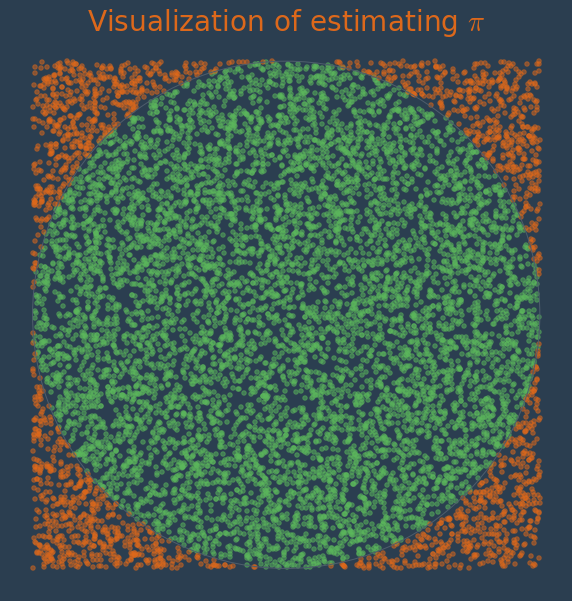

In [5]:
(figure, axes) = plt.subplots(figsize=(10,10))
axes.scatter(*zip(*points_inside), color=colors[1], alpha=0.5)
axes.scatter(*zip(*points_outside), color=colors[0], alpha=0.5)
circle = plt.Circle((0, 0), 1, fill=False)
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.add_artist(circle)
axes.set_title("Visualization of estimating $\pi$", fontsize=28)
nbutil.hide_axes(axes)
plt.show()

A Python translation of the C and Fortran [Pi examples](https://computing.llnl.gov/tutorials/parallel_comp/#ExamplesPI) from the [LLNL parallel computing tutorials](https://computing.llnl.gov/tutorials/parallel_comp/):

In [6]:
def estimate_pi(points):
    in_circle = 0
    for _ in range(int(points)):
        (x, y) = (random.random(), random.random())
        if (x ** 2 + y ** 2) <= 1:
            in_circle += 1
    return 4 * in_circle / points

When we time this with 100 million points, it takes over a minute:

In [7]:
%%time
print(estimate_pi(1e8))

3.14157116
CPU times: user 1min 10s, sys: 151 ms, total: 1min 10s
Wall time: 1min 11s


As soon as we've built our cluster, we'll run this across our workers and compare results. So let's start building!

### Creating the ZeroMQ Components

In order to use the ZeroMQ "pipeline" pattern (dispatching tasks to workers and having workers forward results on to a collector), we'll need to make sure each of the following components is implemented:

 * a distributor
 * a worker (multiple instances of)
 * a collector (for the results)
 
As stated before, the code for our components were adapted from code from the ZeroMQ guide -- originally contributed by Lev Givon and Jeremy Avnet. We've made several changes, one of which is to utilize the ``multiprocessing`` module, thus enabling us to run the example in one terminal window rather than three. Naturally, this also lets us run the example from this notebook. 

We've decided to implement our cluster in several small modules in order to keep things as clear and organized as possible. This should make it fairly obvious what code is responsible for what functionality. We'll start where everything begins: the ``demo`` module:

In [8]:
nbutil.pycat("../lib/demo.py")

The ``main`` function performs the following tasks:

* creates a worker pool with a worker count as configured in ``democfg``
* starts the collector process which will be responsible for processing results from the workers
* starts the distributor process which will start sending the messages to kick everything off

Note that the distributor process gets passed the actual "tasks" we create here in ``demo.main``.

Next we'll look at the *distributor* code:

In [9]:
nbutil.pycat("../lib/distributor.py")

The ``distributor.distribute`` function takes as an argument the list of tasks it will be passing out to workers. Before it gives out any jobs, though, it sets up ZeroMQ sockets for communicating with the other components:
 * the ``sender`` socket for passing out jobs
 * the ``syncher`` socket for kicking off the batch

If you're not familiar with ZeroMQ, don't be alarmed that the ``worker.work`` function isn't called; what happens instead is a message gets passed to the ZeroMQ queue upon which the worker is listening.

Next up, the worker:

In [10]:
nbutil.pycat("../lib/worker.py")

The ``worker.work`` function creates a worker that listens on a ZeroMQ ``PULL`` connection where it will take the task data that the *distributor* ``PUSH``ed. The worker then calls another function that will do the actual computation for the task. Once this has finished, the worker will send the result on to the *collector*.

The code for the worker is a little more complex than the distributor, primarily because the worker polls two separate queues:
 * one from which it will pull the task data, and
 * one on which it is listening for "control" messages -- in particular, a "stop" message

The result that gets sent to the collector is created in a separate module:

In [11]:
nbutil.pycat("../lib/tasker.py")

Now let's see the *collector*:

In [12]:
nbutil.pycat("../lib/collector.py")

This code is almost as simple as that for the distributor. The ``collector.collect`` does a few things:

* ``PULL``s data that was ``PUSH``ed by the workers
* calls ``processor.process`` on all the data that it ``PULL``ed
* sends a control message for stopping as soon as it finishes processing the results

Here's the code that actually processes the results:

In [13]:
nbutil.pycat("../lib/processor.py")

The fact that we have split this into distinct functions may seem like useless work right now, but this will provide some convenience when we update the code to plot our data.

Before we try out our cluster, there's one more module we should look at, so that there's no mystery: the ``democfg`` module referenced by the others:

In [14]:
nbutil.pycat("../lib/democfg.py")

### Working with Results

If we scroll back up to the ``demo`` module, we see that when the module is called from the command line, it:

* gets a total task count
* partitions this into equal segments which represent the "task"
* calls the ``main`` function, passing this parititiond data

Let's try it now:

In [15]:
%%time
%%bash
python ../lib/demo.py

Starting task workers ...
Starting task collector ...
Starting task distributor ...
Processing result: 3.14210336
Processing result: 3.1415472
Processing result: 3.14151648
Processing result: 3.14219872
Processing result: 3.14187168
Processing result: 3.14149984
Processing result: 3.14178592
Processing result: 3.14194304
Final result: 3.14180828
CPU times: user 3.05 ms, sys: 8.41 ms, total: 11.5 ms
Wall time: 25.4 s


As we might have expected, our parallel version runs faster -- more than twice as fast -- than the single-process version. However, we don't even get close to 8 times as fast. From this we might infer that there is overhead above and beyond the simple computation which we have parallelized. To understand exactly what is impacting the performance of our cluster code, we would need to profile the code and analyze the results.

The next thing we'd like to be able to do is integrate matplotlib so we can plot our results. However, our data is handled in separate processes. We could use any number of approaches to solve this problem (e.g., anything from databases to creating an on-notebook ZeroMQ socket to receive data), but let's do something simple right now. Make the following changes to ``./lib/processor.py``:

```python
import numpy as np

def process(receiver):
    results = get_results(receiver)
    np.save("../data/results.npy", np.array(results))
    return results
```

We haven't muddied the logic encapsulated in the ``get_results`` function and because we're still using the ``process`` function, no code in other modules needs to be updated.

We do need to reload some modules, though:

In [16]:
import imp
imp.reload(collector)
imp.reload(processor)
imp.reload(demo)

<module 'demo' from '../lib/demo.py'>

Let's run the ``demo.main`` function, passing it some "tasks", the results of which will be saved to our NumPy file:

In [17]:
tasks = [1e8 / democfg.task_count] * democfg.task_count
demo.main(tasks)

Starting task workers ...
Starting task collector ...
Starting task distributor ...


If you didn't see all the expected output and you've checked your system process table and there are not eight Python processes running at high CPU), then the job has finished and you might need to flush ``stdout``:

In [18]:
sys.stdout.flush()

Processing result: 3.14124992
Processing result: 3.14037024
Processing result: 3.1411328
Processing result: 3.14301344
Processing result: 3.1412272
Processing result: 3.14260256
Processing result: 3.14093152
Processing result: 3.1416672
Final result: 3.14152436


With the data saved, we can load it and plot it:

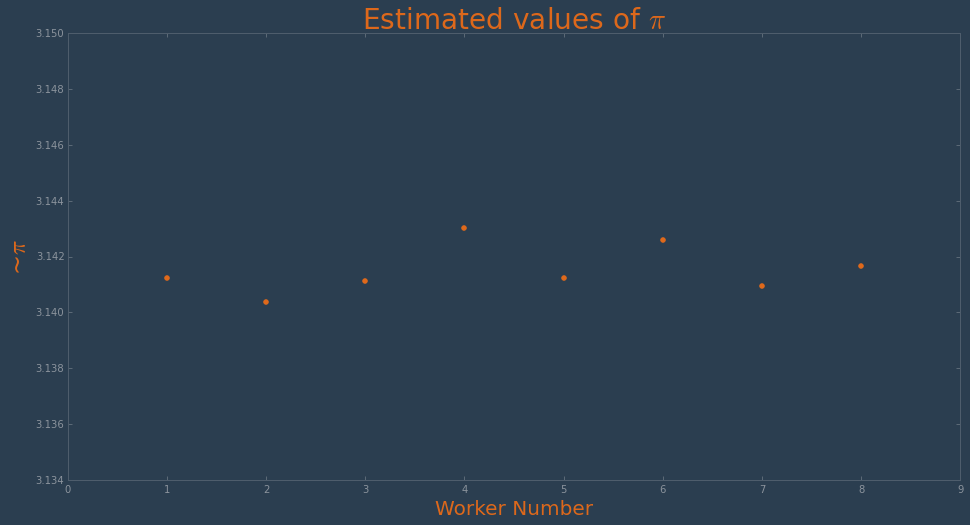

In [19]:
results = np.load("../data/results.npy")
(figure, axes) = plt.subplots(figsize=(16, 8))
axes.scatter([x + 1 for x in range(len(results))], results, color=colors[0])
axes.set_title("Estimated values of $\pi$", fontsize=28)
axes.set_ylabel("~$\pi$", fontsize=24)
axes.set_xlabel("Worker Number", fontsize=20)
plt.show()

## IPython Clusters

### About Parallelism in IPython

As explained in the [IPython documentation for parallel computing](http://ipython.org/ipython-doc/dev/parallel/parallel_intro.html), IPython has built-in support for parallelism due to the architectural overhaul it received when the project moved to ZeroMQ. One can summarize this with the following components which live in the ``IPython.parallel`` package:

* The IPython engine
* The IPython hub
* The IPython schedulers
* The controller client

<img src="ipy-overview.png" />

Due to this architecture, IPython supports the following different styles of parallelism:

* Single program, multiple data
* Multiple program, multiple data
* Message passing using MPI
* Task farming
* Data parallel
* Combinations of these approaches
* Custom user defined approaches

Practically speaking, this allows IPython users to tackle the following use cases:

* Quickly parallelize algorithms that are embarrassingly parallel using a number of simple approaches. Many simple things can be parallelized interactively in one or two lines of code.
* Steer traditional MPI applications on a supercomputer from an IPython session on your laptop.
* Analyze and visualize large datasets (that could be remote and/or distributed) interactively using IPython and tools like matplotlib/TVTK.
* Develop, test and debug new parallel algorithms (that may use MPI) interactively.
* Tie together multiple MPI jobs running on different systems into one giant distributed and parallel system.
* Start a parallel job on your cluster and then have a remote collaborator connect to it and pull back data into their local IPython session for plotting and analysis.
* Run a set of tasks on a set of CPUs using dynamic load balancing.

### Getting Started

To use IPython for parallel computing, you need to start one instance of the controller and one or more instances of the engine. Initially, it is best to simply start a controller and engines on a single host using the ``ipcluster`` command. To start a controller and 4 engines on your localhost, switch to a terminal window with this notebook's virtual environment activated and execute the following:

```
$ ipcluster start -n 4
```

This will run the ipcluster app in the foreground, showing output such as:

```
2015-04-28 09:50:29.584 [IPClusterStart] Using existing profile dir: '/Users/oubiwann/.ipython/profile_default'
2015-04-28 09:50:29.587 [IPClusterStart] Starting ipcluster with [daemon=False]
2015-04-28 09:50:29.589 [IPClusterStart] Creating pid file: /Users/oubiwann/.ipython/profile_default/pid/ipcluster.pid
2015-04-28 09:50:29.589 [IPClusterStart] Starting Controller with LocalControllerLauncher
2015-04-28 09:50:30.593 [IPClusterStart] Starting 4 Engines with LocalEngineSetLauncher
```

### Direct View

The “direct view” is called such because the DirectView object offers an interface to the cluster which doesn't go through the schedulers, but instead offers direct, manual execution control.

In [20]:
from IPython.parallel import Client
client = Client() 
client.ids 

[0, 1, 2, 3]

In [21]:
view = client.direct_view()
view

<DirectView all>

In [22]:
async_result = view.apply(np.random.rand, 2, 2)
async_result

<AsyncResult: finished>

In [23]:
values = async_result.get()
values

[array([[ 0.07792881,  0.21319405],
        [ 0.20925777,  0.74999169]]), array([[ 0.07792881,  0.21319405],
        [ 0.20925777,  0.74999169]]), array([[ 0.07792881,  0.21319405],
        [ 0.20925777,  0.74999169]]), array([[ 0.07792881,  0.21319405],
        [ 0.20925777,  0.74999169]])]

In [24]:
async_result = view.apply(np.linalg.eigvals, values)
async_result

<AsyncResult: eigvals>

In [25]:
async_result.get()

[array([[ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029]]), array([[ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029]]), array([[ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029]]), array([[ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029],
        [ 0.01706021,  0.81086029]])]

### Load Balanced View

In contrast to the Direct View, IPython offers a view which does not bypass the schedulers, but instead executes based upon the configured load-balancing scheme.

There are a variety of valid ways to determine where jobs should be assigned in a load-balancing situation. IPython support several standard schemes, and even provides the means by which developers may easily add their own. The scheme can be selected via the ``scheme`` argument to ``ipcontroller``, or in the ``TaskScheduler.schemename`` attribute of a controller config object.

The built-in routing schemes provided by IPython are: 

* lru: Least Recently Used
* plainrandom: Plain Random
* twobin: Two-Bin Random
* leastload: Least Load (default)
* weighted: Weighted Two-Bin Random

To select one of these schemes, simply use the ``ipcontroller`` command line tool: 

```
$ ipcontroller --scheme=twobin
``` 

In [26]:
lb_view = client.load_balanced_view()
lb_view

<LoadBalancedView None>

In [27]:
serial_result = map(lambda x:x**10, range(32))
parallel_result = lb_view.map(lambda x:x**10, range(32))

In [28]:
list(serial_result) == parallel_result.get()

True

In [29]:
@lb_view.parallel()
def f(x):
    return 10.0*x**4

f.map(range(32)).get()

[0.0,
 10.0,
 160.0,
 810.0,
 2560.0,
 6250.0,
 12960.0,
 24010.0,
 40960.0,
 65610.0,
 100000.0,
 146410.0,
 207360.0,
 285610.0,
 384160.0,
 506250.0,
 655360.0,
 835210.0,
 1049760.0,
 1303210.0,
 1600000.0,
 1944810.0,
 2342560.0,
 2798410.0,
 3317760.0,
 3906250.0,
 4569760.0,
 5314410.0,
 6146560.0,
 7072810.0,
 8100000.0,
 9235210.0]

### Magics

In [30]:
with view.sync_imports():
    import numpy

importing numpy on engine(s)


In [31]:
%px async_result = numpy.random.rand(2, 2)

In [32]:
%px numpy.linalg.eigvals(async_result)

Out[0:2]: array([ 1.69123631,  0.0052597 ])

Out[1:2]: array([ 1.4345667 ,  0.15208336])

Out[2:2]: array([ 1.24709664, -0.06577105])

Out[3:2]: array([ 0.39707627,  1.01065811])

### Example: Estimating Pi

Let's use IPython's clustering features to run the same job that we did with our implementation of the ZeroMQ pattern. Go ahead and stop the 4-node cluster and restart with 8 nodes:

```
$ ipcluster start -n 8
```

Let's get a fresh connection which is aware of the new nodes:

In [33]:
client = Client() 
client.ids 

[0, 1, 2, 3, 4, 5, 6, 7]

In [34]:
view = client.direct_view()
view.block = True
with view.sync_imports():
    import random

importing random on engine(s)


In [35]:
%%time
node_count = 8
results = view.apply(estimate_pi, 1e8 / node_count)
pi_est = sum(results)/len(client.ids)
print("Result: {}".format(pi_est))

Result: 3.14143816
CPU times: user 6.98 s, sys: 685 ms, total: 7.66 s
Wall time: 19.6 s


That runs faster than our custom multiprocessing ZeroMQ example, is almost four times faster than the original serial example we gave, but all things being equal it's biggest advantage is that it's *much* easier to set up :-) However, thanks to the work we did in the previous section, we have an idea of what's going on behind the scenes (since IPython uses ZeroMQ).

In addition to being easier to set up, it's easier to plot the results:

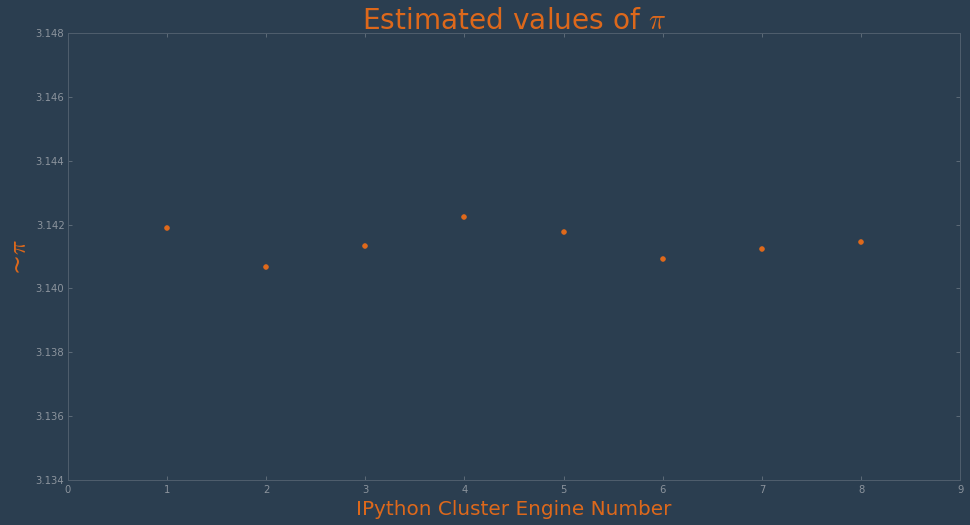

In [36]:
(figure, axes) = plt.subplots(figsize=(16, 8))
axes.scatter([x + 1 for x in range(len(results))], results, color=colors[0])
axes.set_title("Estimated values of $\pi$", fontsize=28)
axes.set_ylabel("~$\pi$", fontsize=24)
axes.set_xlabel("IPython Cluster Engine Number", fontsize=20)
plt.show()

### Example: Computing Periods of Stars

The following example is a partial representation of [graduate course assignment](http://www.astro.washington.edu/users/vanderplas/Astr599/notebooks/21_IPythonParallel) in scientific computing taught by Jake Vanderplas through the University of Washington Astronomy department. The actual assignment is much more involved than what is provided below!

In [37]:
from astroML.datasets import fetch_LINEAR_sample
from astroML.time_series import lomb_scargle

In [38]:
lcs = fetch_LINEAR_sample()
id_ = lcs.ids[0]
time, flux, dflux = lcs[id_].T

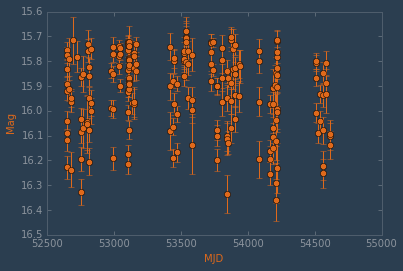

In [39]:
plt.errorbar(time, flux, yerr=dflux, fmt="o")
plt.gca().invert_yaxis()
plt.xlabel("MJD")
plt.ylabel("Mag")
plt.show()

In [40]:
periods = np.logspace(-2, 0, 10000)
periodogram = lomb_scargle(time, flux, dflux, omega=2 * np.pi / periods, generalized=True)

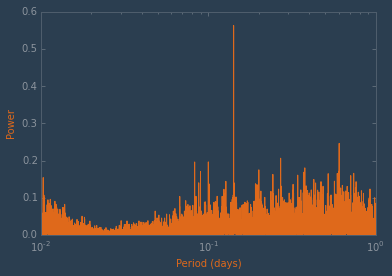

In [41]:
plt.plot(periods, periodogram)
plt.semilogx()
plt.xlabel("Period (days)")
plt.ylabel("Power")
plt.show()

In [42]:
idx = np.argsort(periodogram)
max_period = periods[idx[-1]]
phase = time / max_period - time // max_period 
(min(phase), max(phase))

(0.015862399188335985, 0.99456532095791772)

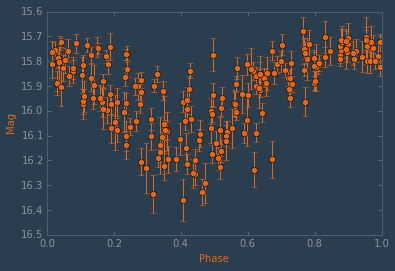

In [43]:
plt.errorbar(phase, flux, yerr=dflux, fmt="o")
plt.gca().invert_yaxis()
plt.xlabel("Phase")
plt.ylabel("Mag")
plt.show()

In [44]:
g_r = lcs.get_target_parameter(id_, 'gr')
g_r

0.81000000000000005

In [45]:
lb_view = client.load_balanced_view()
lb_view.block = True

In [46]:
@lb_view.parallel()
def f(idx):
    import numpy as np
    from astroML.datasets import fetch_LINEAR_sample
    from astroML.time_series import lomb_scargle
    lcs = fetch_LINEAR_sample()
    id_ = lcs.ids[idx]
    time, flux, dflux = lcs[id_].T
    periods = np.logspace(-2, 0, 10000)
    periodogram = lomb_scargle(
        time, flux, dflux,
        omega=2 * np.pi / periods, generalized=True)
    sorted_periods = np.argsort(periodogram)
    max_period = periods[sorted_periods[-1]]
    g_r = lcs.get_target_parameter(id_, 'gr')
    return (max_period, g_r, flux, dflux)

In [47]:
results = f.map(range(1000))

In [103]:
x = [i[0] for i in results]
y = [i[1] for i in results]
flux = [i[2].mean() for i in results]
dflux = [i[3].mean() for i in results]

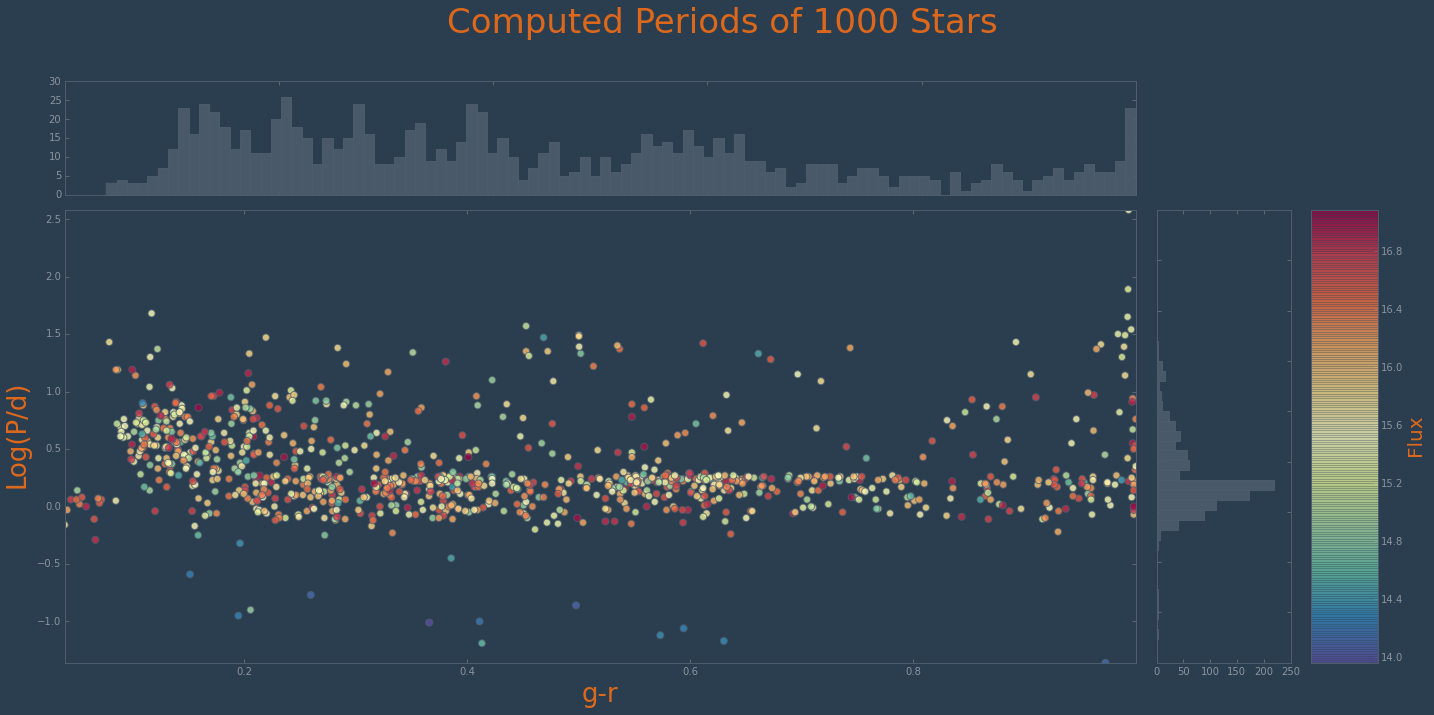

In [139]:
figure = plt.figure(figsize=(20, 10))
gs_master = mpl.gridspec.GridSpec(3, 3, height_ratios=[1, 4, 16], width_ratios=[16, 2, 1])

# Layer 1 - Title
gs_1 = mpl.gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_master[0, :])
title_axes = figure.add_subplot(gs_1[0])
title_axes.set_title("Computed Periods of 1000 Stars", fontsize=34)
hide_axes(title_axes)

# Layer 2 - Histogram 1
gs_2 = mpl.gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_master[1, :1])
hist1_axes = figure.add_subplot(gs_2[0])
hist1_axes.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
hist1_axes.hist(x, bins=100, color=colors[5], alpha=0.9)

# Layer 3 - Scatter
gs_31 = mpl.gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_master[2, :1])
scatter_axes = figure.add_subplot(gs_31[0, :])
scatter_axes.scatter(x, y, c=flux, s=50, alpha=0.8, cmap=mpl.cm.Spectral_r)
scatter_axes.set_xlim(min(x), max(x))
scatter_axes.set_ylim(min(y), max(y))
scatter_axes.set_ylabel("Log(P/d)", fontsize=26)
scatter_axes.set_xlabel("g-r", fontsize=26)

# Layer 3 - Histogram 2
gs_32 = mpl.gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_master[2, 1])
hist2_axes = figure.add_subplot(gs_32[0])
hist2_axes.yaxis.set_major_formatter(mpl.ticker.NullFormatter())
hist2_axes.hist(y, bins=40, color=colors[5], alpha=0.9, orientation='horizontal')

# Layer 3 - Colorbar
gs_33 = mpl.gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_master[2, 2:3])
cb_axes = figure.add_subplot(gs_33[0])
cb = mpl.colorbar.ColorbarBase(
    cb_axes, alpha=0.5, cmap=mpl.cm.Spectral_r,
    norm=mpl.colors.Normalize(vmin=min(flux), vmax=max(flux)))
cb.set_label("Flux", fontsize=20)

# Tidy up
gs_master.tight_layout(figure)
plt.show()

## MIT's StarCluster

Note: this section is incomplete.

### About StarCluster

The next clustering option we'll look at in detail is MIT's StarCluster. From their docs site:

<blockquote>StarCluster is an open source cluster-computing toolkit for Amazon’s Elastic Compute Cloud (EC2). StarCluster has been designed to simplify the process of building, configuring, and managing clusters of virtual machines on Amazon’s EC2 cloud.
</blockquote>

<img src="sc-overview.png" />

StarCluster was developed at MIT for both use by researchers as well as instruction in the classroom. Early uses of it included protein visualization, genetic simulation, and quantum mechanical computations in molecular dynamics. 

StarCluster takes care of the heavy lifting when it comes to creating and configuring a cluster on EC2. StarCluster configures the following items out-of-the-box:

* Security Groups
* User-friendly Hostnames
* User Accounts
* Password-less SSH
* NFS Shares
* EBS Volumes
* Queueing System
* Scratch Space
* Extensibility via Plugin System
* Cluster Creation and Management
* Dynamic Cluster Resizing
* Easy Data Copying to and from Clusters

StarCluster is written in Python using the boto, crypto, and paramiko libraries, among others. It supports various Amazon OS images and multiple versions of those OSs. 

### Code and Images

We have made modifications to StarCluster and some of its dependencies in order to run on Python 3. This notebook's dependencies download the following Python 3 versions of libraries:

* https://github.com/oubiwann/StarCluster
* https://github.com/oubiwann/optcomplete
* https://github.com/oubiwann/workerpool

Note that these are still in an experimental state, but are suitable for our needs.

We have created an updated StarCluster AMI with Ubuntu 14.04.2 LTS and IPython for Python 2 and 3, as well as the many scientific computing libraries you've come to know and love:
 * [ami-a73c0a97](https://console.aws.amazon.com/ec2/v2/home?region=us-west-2#LaunchInstanceWizard:ami=ami-a73c0a97)
 
Only one region was used for the example in this notebook; if you would like to run in an AWS EC2 region other than ``us-west-2``, search for "ami-a73c0a97" in the "AMIs" pane of your AWS web console, and then from the "Actions" drop-down, select "Copy". You will then be presented with a dialog box where you can select a region as well as give it a name and description.

A best attempt was made at securing the AMI according to the instructions provided by Amazon [here](https://aws.amazon.com/articles/0155828273219400). However, no guarantees are made -- as usual, use at your own risk.

### Configuring StarCluster

In the process of running ``make`` for this notebook, you will have downloaded and installed all the dependencies. In a terminal, activate the Python virtual environment from the directory you started this notebook:

```
. ../.venv-mmpl/bin/activate
```

Now the ``startcluster`` command line utility will be available to you. Let's use it to create a default configuration file for you:

```
$ starcluster help
```
```
StarCluster - (http://star.mit.edu/cluster) (v. 0.95.7+py3k-oubiwann)
Software Tools for Academics and Researchers (STAR)
Please submit bug reports to starcluster@mit.edu
!!! ERROR - config file /Users/oubiwann/.starcluster/config does not exist

Options:
--------
[1] Show the StarCluster config template
[2] Write config template to /Users/oubiwann/.starcluster/config
[q] Quit

Please enter your selection: 2
```

At which point your configuration will be generated:

```
>>> Config template written to /Users/oubiwann/.starcluster/config
>>> Please customize the config template
```

You will need to make the following edits to your new ``~/.starcluster/config`` file:
 * Add a value for the ``AWS_ACCESS_KEY_ID`` entry
 * Add a value for the ``AWS_SECRET_ACCESS_KEY`` entry
 * Add a value for the ``AWS_USER_ID`` entry
 * If you are using a different region than the default of ``us-east-1``:
   * Uncomment and set a value for ``AWS_REGION_NAME`` 
   * Uncomment and set a value for ``AWS_REGION_HOST`` for your chosen region
 * Change the value for ``KEY_LOCATION`` to the key ``.pem`` file you downloaded from AWS (this is the full path and filename, including the ``.pem`` file extension)
 * Change the value for ``KEYNAME`` to the filename of the ``.pem`` file, without the extension
 * Change the value for ``NODE_IMAGE_ID`` to the AMI ID given above: ``ami-a73c0a97``
 * Change the value for ``CLUSTER_SIZE`` to ``1`` -- we will add more shortly
 


### Starting a Cluster

With these changes in place, we're ready to start up our cluster:

```
$ starcluster start my-cluster-name
```

At which point you will start to see output as StarCluster makes requests to AWS for starting up (and waiting for) nodes. You will see ASCII progress bars and/or status messages for things such as:
 * Waiting for the instances to come up
 * Waiting for SSH to be ready on all nodes
 * Cluster configuration
 * Setting up NFS
 * Setting up SSH keys
 * Setting up Sun Grid Engine

You can expect a four-node cluster to take about 3-4 minutes for a complete start up.

### Running a Job

TBD

## IPython Clusters Revisited

TBD